In [144]:

# https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

# Typical usage:
# >>> exec(open("mnist_agrawal2.py").read())
# >>> train(net_agrawal)
# >>> predict(net_agrawal, [ X_test[0] ])

# Note that training does NOT use the X_test images in any way

# Check 1st 10 test predictions:
# for i in range(10):
#     p = predict(net_agrawal,[X_test[i]])
#     print(f"Image {i} predict {p} vs {y_test[i]}")

from __future__ import print_function
import numpy as np ## For numerical python
import tensorflow.keras as keras
from tqdm import trange
from IPython.display import clear_output

import matplotlib.pyplot as plt
#matplotlib inline                 # UNCOMMENT for JUPYTER

np.random.seed(42)

class Layer:

    #A building block. Each layer is capable of performing two things:
    #- Process input to get output:           output = layer.forward(input)

    #- Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    #Some layers also have learnable parameters which they update during layer.backward.

    def __init__(self):
        # Here we can initialize layer parameters (if any) and auxiliary stuff.
        # A dummy layer does nothing
        pass

    def forward(self, input):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]

        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        # Performs a backpropagation step through the layer, with respect to the given input.
        # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        # d loss / d x  = (d loss / d layer) * (d layer / d x)
        # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        # If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]

        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input) # chain rule

class ReLU(Layer):
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass

    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0,input)
        return relu_forward

    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output * relu_grad # This relies on the quirk Python True === 1, False === 0
    
class Sigmoid(Layer):
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass

    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
         return 1 / (1 + math.exp(-input))

    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output * relu_grad # This relies on the quirk Python True === 1, False === 0
    
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b

        self.learning_rate = learning_rate

        # initialize weights with small random numbers. We use normal initialization
        self.weights = np.random.normal(loc=0.0,
                                        scale = np.sqrt(2/(input_units+output_units)),
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)

    def forward(self,input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b

        # input shape: [batch, input_units]
        # output shape: [batch, output units]

        return np.dot(input,self.weights) + self.biases

    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)

        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # Here we perform a stochastic gradient descent step.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

#Loss function
def softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[:,reference_answers]
    #print("np.arange(len(logits): ", np.arange(len(logits)))

    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test

# Compute activations of all network layers by applying them sequentially.
# Return a LIST of LISTS: activations for each layer.
def forward(network, X):

    activations = []
    input = X
    # Looping through each layer passing output of each as input of next
    for layer in network:
        activations.append(layer.forward(input))
        # Updating input to last layer output
        input = activations[-1]

    assert len(activations) == len(network)
    return activations

# predict(network layer list, samples array)
# X.shape is (N,784), i.e. a list of flattened MNIST images
# logits.shape is (N,10)
# return shape is (N,) i.e. a list of categories (0..9), one for each input image
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1] # forward() returns the entire network stack of output values, so the final [-1] set is net output

    return logits.argmax(axis=-1) # argmax returns the index of the highest element

# infer() is the same as predict(), but for a single image and printing more readable results
def infer(network, image):
    logits = forward(network,[image])[-1] # as predict(), converting image into a list
    # logits.shape is (1,10), i.e. the output of the final layer for a single image
    print_image(image)
    print_logits(logits[0])
    print_category(logits.argmax(axis=-1))

def train_batch(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.


    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  # NOTE "+" here concatenates [X] and layer_activations. layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]

        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates

    return np.mean(loss)

# An untested function to work out if we're running in IPython/Jupyter or not (returns False ok in Python command line)
def in_ipython():
    try:
        x = get_ipython()
        return True
    except NameError:
        return False

# Python ITERATOR that yeilds slices of X and y
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def train(network, batchsize=32, shuffle=True):
    # We'll accumulate a log of accuracy figures for the training dataset and validation data set
    train_accuracy = []
    val_accuracy = []

    for epoch in range(700): # Was 25 epochs
        print("Epoch",epoch)

        # With default batch size of 32, and 50,000 samples, this will iterate through 1562 batches
        # iterate_minibatches simply chops up X_train, y_train into 32-
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batchsize,shuffle=shuffle):
            train_batch(network,x_batch,y_batch)
#         print("predict", predict(network,X_train))
        train_accuracy.append(np.mean(predict(network,X_train)==y_train)) #np.mean of true false will give how many true/how many
        val_accuracy.append(np.mean(predict(network,X_val)==y_val))

        if in_ipython():
            clear_output()
        print("Train accuracy:", train_accuracy)
        print("Train accuracy:",train_accuracy[-1])
        print("Val accuracy:",val_accuracy[-1])
        if in_ipython():
            plt.plot(train_accuracy,label='train accuracy')
            plt.plot(val_accuracy,label='val accuracy')
            plt.legend(loc='best')
            plt.grid()
            plt.show()

    ## Let's look at some example
#     if in_ipython():
#         plt.figure(figsize=[6,6])
#         for i in range(4):
#             plt.subplot(2,2,i+1)
#             plt.title("Label: %i"%y_train[i])
#             plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

# My code
def test(network, X_test, y_test):
        logits = forward(network,X_test)[-1]
        print(logits)
        accuracy = np.mean(predict(network,X_test)==y_test)
        print(predict(network,X_test)[0])
        for i in range(len(X_test)):
            if predict(network,X_test)[i] != y_test[i]:
                print(predict(network,X_test)[i])
                print_image(X_test[i])
        print(f"test data accuracy: {accuracy}")

# Print a 784 x 1 image to the console
def print_image(image):
    for i in range(28):
        for j in range(28):
            print( '  ' if image[i*28+j] > 0.5 else '00', end='')
        print()

# Print logits
def print_logits(logits):
    for n in logits:
        print(f"{n:.3f} ",end='')
    print()

# Print category, e.g. 0 -> "ZERO"
# Python 3.10 only
def print_category(n):
    match n:
        case 0:
            print("ZERO")
        case 1:
            print("ONE")
        case 2:
            print("TWO")
        case 3:
            print("THREE")
        case 4:
            print("FOUR")
        case 5:
            print("FIVE")
        case 6:
            print("SIX")
        case 7:
            print("SEVEN")
        case 8:
            print("EIGHT")
        case 9:
            print("NINE")
        case _:
            print("ERROR")

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

print(f"X_train is {X_train.shape}")
print(f"X_val is {X_val.shape}")
print(f"X_test is {X_test.shape}")
print("X_test[0] is:")

print_image(X_test[0])

net_agrawal2= [
    Dense(784,100),
    ReLU(),
    Dense(100,200),
    ReLU(),
    Dense(200,10)
]

net_james3= [
    Dense(784,3000),
    ReLU(),
    Dense(3000,6),
    ReLU(),
    Dense(6,10),
    ReLU(),
    Dense(10,100),
    ReLU(),
    Dense(100,200),
    ReLU(),
    Dense(200,10)
]


X_train is (50000, 784)
X_val is (10000, 784)
X_test is (10000, 784)
X_test[0] is:
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000      000000000000000000000000000000000000
000000000000                              00000000000000
00000000000000000000                        000000000000
00000000000000000000000000000000000000    00000000000000
00000000000000000000000000000000000000    00000000000000
000000000000000000000000000000000000    0000000000000000
0000000000000000000000000000000000      0000000000000000
0000000000000000000000000000000000    000000000000000000
00000000000000000000000000000000      000000000000000000
00000

Train accuracy: [0.95356, 0.97832, 0.96328, 0.98974, 0.9904, 0.99234, 0.99166, 0.99298, 0.99306, 0.99316, 0.99706, 0.99534, 0.9951, 0.99218, 0.99612, 0.99868, 0.99804, 0.99908, 0.99882, 0.99932, 0.99972, 0.99934, 0.99942, 0.99886, 0.99966, 0.99986, 0.99954, 0.99728, 0.9994, 0.99872, 0.99946, 0.99972, 0.99868, 0.99974, 0.99992, 0.99996, 0.99998, 0.99998, 0.99998, 0.99998, 0.99998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

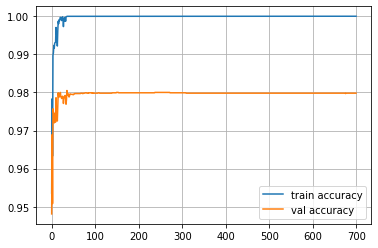

[[ 4.36984852e-01 -1.19426334e+00  1.57192863e+00 ...  3.72903910e+01
  -2.14697171e+01  1.89297658e+00]
 [-2.29729343e+01  7.57389603e+00  6.17547303e+01 ...  1.68715683e+01
   3.22606182e-02 -3.24425215e+01]
 [-1.32068677e+01  3.71115146e+01  6.82594359e+00 ...  7.20324586e+00
   2.91143864e+00 -3.29115998e+00]
 ...
 [-1.56888390e+01  1.79607132e+00 -8.58450621e-01 ... -4.35378889e+00
  -9.82570810e+00  3.28422952e-01]
 [-5.19928259e-01 -1.69641348e+01 -7.40300117e+00 ... -2.46015413e+01
   4.48210464e+00 -6.93813139e-01]
 [-5.72437999e+00 -2.28708934e+01  1.15065049e+01 ... -1.19359827e+00
  -3.92223820e+00 -2.63227404e+01]]
7
6
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000  0000000000
00000000000000000000000000000000                  000000
000000000000000000

3
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000  0000000000000000000000
000000000000000000000000000000      00000000000000000000
0000000000000000000000000000        00000000000000000000
00000000000000000000000000        0000000000000000000000
00000000000000000000000000        0000000000000000000000
000000000000000000000000        000000000000000000000000
000000000000000000000000        000000000000000000000000
000000000000000000000000        000000000000000000000000
000000000000000000000000          0000000000000000000000
00000000000000000000000000        0000000000000000000000
00000000000000000000000000          00000000000000000000
000000000000000000000000000000        000000000000000000
000000000000000000000000000000          0000000000000000
0000000000000000000000000000000000      0000000000000000
00000000000000000000000000000

2
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000000000        00000000000000000000
0000000000000000000000000000        00000000000000000000
00000000000000000000000000000000      000000000000000000
00000000000000000000000000000000      000000000000000000
00000000000000000000000000000000      000000000000000000
00000000000000000000000000000000    00000000000000000000
00000000000000000000000000000000    00000000000000000000
000000000000000000000000000000      00000000000000000000
000000000000000000000000000000    0000000000000000000000
000000000000000000000000  00    000000000000000000000000
000000000000000000000000        000000000000000000000000
0000000000000000000000          000000000000000000000000
000000000000000000        0000    0000000000000000000000
0000000000000000      0000000

3
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
00000000000000000000000000      000000000000000000000000
00000000000000000000000000      000000000000000000000000
000000000000000000000000        000000000000000000000000
000000000000000000000000    00  000000000000000000000000
000000000000000000000000000000  000000000000000000000000
000000000000000000000000000000    0000000000000000000000
00000000000000000000000000000

8
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000  0000      000000000000000000000000000000
00000000000000                            00000000000000
00000000000000      00000000              00000000000000
0000000000000000    0000000000      00000000000000000000
0000000000000000    0000000000    0000000000000000000000
0000000000000000    0000000000    0000000000000000000000
0000000000000000      000000    000000000000000000000000
000000000000000000    000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000 

9
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000000000  00  0000000000000000000000
0000000000000000000000000000      0000000000000000000000
00000000000000000000000000        0000000000000000000000
00000000000000000000000000        0000000000000000000000
000000000000000000000000    00    0000000000000000000000
0000000000000000000000    0000    0000000000000000000000
0000000000000000000000  000000    0000000000000000000000
00000000000000000000    000000  000000000000000000000000
00000000000000000000  00000000  000000000000000000000000
00000000000000000000  00000000  000000000000000000000000
00000000000000000000    0000        00000000000000000000
0000000000000000000000       

4
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000      000000000000000000000000000000000000
00000000000000      000000000000000000000000000000000000
00000000000000      000000000000000000000000000000000000
000000000000      00000000000000000000000000000000000000
000000000000      00000000000000000000000000000000000000
000000000000      000000000000000000  000000000000000000
000000000000      0000000000000000        00000000000000
000000000000    000000000000000000          000000000000
000000000000    0000000000000000            000000000000
0000000000      0000000000000000            000000000000
0000000000      0000000000000000            000000000000
0000000000      0000000000000000            000000000000
0000000000      0000000000000000            000000000000
000000000000      00000000000000            000000000000
000000000000      00000000000

6
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000    00000000000000000000
00000000000000000000000000000000      000000000000000000
00000000000000000000000000000000    00000000000000000000
000000000000000000000000000000      00000000000000000000
000000000000000000000000000000    0000000000000000000000
0000000000000000000000000000      0000000000000000000000
0000000000000000000000000000    000000000000000000000000
00000000000000000000000000      000000000000000000000000
00000000000000000000000000    00000000000000000000000000
000000000000000000000000    00000000    0000000000000000
000000000000000000000000    000000      0000000000000000
0000000000000000000000    00000000    000000000000000000
00000000000000000000                        00  00000000
00000000000000000000                            00000000
000000000000000000                      0000000000000000
0000000000000000        00000

8
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000            000000000000000000
000000000000000000000000              000000000000000000
00000000000000000000          0000    000000000000000000
00000000000000000000      000000        0000000000000000
000000000000000000      00000000        0000000000000000
0000000000000000      00000000          0000000000000000
0000000000000000    000000      00    000000000000000000
0000000000000000  000000      0000    000000000000000000
0000000000000000            000000    000000000000000000
000000000000000000      0000000000    000000000000000000
0000000000000000000000000000000000    000000000000000000
00000000000000000000000000000

9
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
000000000000000000000000000000    0000000000000000000000
0000000000000000000000000000        00000000000000000000
00000000000000000000000000            000000000000000000
000000000000000000000000      00      000000000000000000
00000000000000000000        0000      000000000000000000
000000000000000000        000000    00000000000000000000
000000000000000000      000000      00000000000000000000
0000000000000000        000000      00000000000000000000
0000000000000000        000000    0000000000000000000000
000000000000000000    00000000    0000000000000000000000
000000000000000000    0000000

9
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000    00000000000000000000000000
000000000000000000000000        000000000000000000000000
0000000000000000000000            0000      000000000000
00000000000000000000              00        000000000000
000000000000000000          000000            0000000000
0000000000000000          000000            000000000000
0000000000000000        0000              00000000000000
00000000000000                          0000000000000000
00000000000000                          0000000000000000
00000000000000                        000000000000000000
0000000000000000                      000000000000000000
0000000000000000000000000000 

4
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
000000000000000000    0000000000000000000000000000000000
000000000000000000  000000000000000000000000000000000000
000000000000000000  000000000000000000000000000000000000
000000000000000000  000000000000000000000000000000000000
000000000000000000  000000000000000000000000000000000000
000000000000000000  000000000000          00000000000000
000000000000000000  000000000000    00    00000000000000
000000000000000000  0000000000    000000  00000000000000
0000000000000000    0000000000    000000  00000000000000
0000000000000000    0000000000  00000000  00000000000000
0000000000000000    00000000    000000    00000000000000
0000000000000000    00000000    0000    0000000000000000
000000000000000000  00000000    00    000000000000000000
000000000000000000    000000 

8
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000    00    00000000000000
0000000000000000000000000000      0000000000000000000000
00000000000000000000000000    00000000000000000000000000
0000000000000000000000      0000000000000000000000000000
00000000000000000000      000000000000000000000000000000
00000000000000000000      000000000000000000000000000000
000000000000000000      00000000000000000000000000000000
00000000000000000000    00000000000000000000000000000000
0000000000000000000000    000000000000000000000000000000
0000000000000000000000      0000000000000000000000000000
000000000000000000000000      00000000000000000000000000
000000000000000000000000      00000000000000000000000000
00000000000000000000000000   

7
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000000000    000000000000000000000000
00000000000000000000000000        0000000000000000000000
000000000000000000000000    0000      000000000000000000
000000000000000000000000  000000      000000000000000000
0000000000000000000000    00000000    000000000000000000
00000000000000000000    00000000      000000000000000000
00000000000000000000  0000000000    00000000000000000000
000000000000000000    0000000000      000000000000000000
000000000000000000  000000000000    00000000000000000000
000000000000000000  000000000000    00000000000000000000
000000000000000000  0000000000    0000000000000000000000
000000000000000000  000000000

8
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000          00000000000000000000
0000000000000000000000                000000000000000000
0000000000000000000000  0000000000      0000000000000000
00000000000000000000    000000000000      00000000000000
000000000000000000    0000000000000000      000000000000
000000000000000000  00000000000000000000    000000000000
0000000000000000000000000000000000000000    000000000000
0000000000000000000000000000000000000000    000000000000
0000000000000000000000000000        0000    000000000000
00000000000000000000000000                  000000000000
00000000000000000000        0000000000      000000000000
0000000000000000        0000000000000000    000000000000
0000000000000000      0000000000000000    00000000000000
00000000000000    00000000000

2
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000  00  000000000000000000
000000000000000000000000                0000000000000000
00000000000000000000                      00000000000000
000000000000000000                        00000000000000
000000000000000000        00000000      0000000000000000
00000000000000000000000000000000        0000000000000000
0000000000000000000000000000          000000000000000000
00000000000000000000000000          00000000000000000000
0000000000000000000000            0000000000000000000000
00000000000000000000            000000000000000000000000
0000000000000000                      000000000000000000
0000000000000000                      000000000000000000
0000000000000000                        0000000000000000
0000000000000000             

1
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
000000000000000000000000      00000000000000000000000000
000000000000000000            00000000000000000000000000
000000000000000000  00000000  00000000000000000000000000
0000000000000000000000000000  00000000000000000000000000
0000000000000000000000000000  00000000000000000000000000
00000000000000000000000000    00000000000000000000000000
00000000000000000000000000    00000000000000000000000000
00000000000000000000000000    00000000000000000000000000
00000000000000000000000000                            00
00000000000000          00    00000000000000000000000000
00000000000000000000000000  0

6
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000  00000000000000000000
0000000000000000000000000000000000    000000000000000000
00000000000000000000000000000000    00000000000000000000
000000000000000000000000000000    0000000000000000000000
000000000000000000000000000000    0000000000000000000000
0000000000000000000000000000    000000000000000000000000
0000000000000000000000000000    000000000000000000000000
00000000000000000000000000      000000000000000000000000
000000000000000000000000      00000000000000000000000000
0000000000000000000000      0000000000      000000000000
0000000000000000000000    000000000000      000000000000
00000000000000000000      0000000000            00000000
00000000000000000000                            00000000
000000000000000000                          000000000000
0000000000000000        00000

7
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000        0000000000000000000000
00000000000000000000      000000    00000000000000000000
000000000000000000    00000000      00000000000000000000
0000000000000000    000000          00000000000000000000
0000000000000000          000000    00000000000000000000
0000000000000000      0000000000    00000000000000000000
00000000000000000000000000000000    00000000000000000000
00000000000000000000000000000000    00000000000000000000
00000000000000000000000000000000    00000000000000000000
00000000000000000000000000000000    00000000000000000000
00000000000000000000000000000

1
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000    00000000000000000000000000
000000000000000000000000      00000000000000000000000000
000000000000000000000000        000000000000000000000000
0000000000000000000000    00    000000000000000000000000
0000000000000000000000    0000  000000000000000000000000
0000000000000000000000    0000  000000000000000000000000
0000000000000000000000            0000000000000000000000
000000000000000000000000          0000000000000000000000
0000000000000000000000000000    000000000000000000000000
000000000000000000000000000000  000000000000000000000000
000000000000000000000000000000    0000000000000000000000
000000000000000000000000000000    0000000000000000000000
00000000000000000000000000000

9
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000      00000000      0000000000
00000000000000000000  00        000000        0000000000
000000000000000000                00          0000000000
0000000000000000            000000          000000000000
0000000000000000          00000000          000000000000
00000000000000          00000000          00000000000000
00000000000000        00000000            00000000000000
00000000000000                              000000000000
00000000000000                            00000000000000
0000000000000000                      000000000000000000
000000000000000000           

8
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000    00000000000000000000000000
00000000000000000000000000      000000000000000000000000
000000000000000000000000      00000000000000000000000000
000000000000000000000000      000000000000        000000
000000000000000000000000      000000000000        000000
000000000000000000000000    0000000000000000000000000000
0000000000000000000000      0000000000000000000000000000
0000000000000000000000      0000000000000000000000000000
0000000000000000000000      0000000000000000000000000000
0000000000000000000000      0000000000000000000000000000
0000000000000000000000      0000000000000000000000000000
0000000000000000000000      0

3
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000000000        00000000000000000000
0000000000000000000000                000000000000000000
000000000000000000                    000000000000000000
000000000000000000                    000000000000000000
000000000000000000                  00000000000000000000
000000000000000000                0000000000000000000000
00000000000000000000                00000000000000000000
00000000000000000000                  000000000000000000
00000000000000000000                    0000000000000000
00000000000000000000000000000000        0000000000000000
000000000000000000000000000000000000      00000000000000
000000000000000000000000000000000000      00000000000000
00000000000000000000000000000

8
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000000000                000000000000
000000000000000000000000                      0000000000
00000000000000000000                          0000000000
000000000000000000                000000      0000000000
000000000000000000          000000000000      0000000000
0000000000000000          000000000000        0000000000
00000000000000          00000000000000        0000000000
00000000000000        0000000000000000      000000000000
00000000000000        00000000000000        000000000000
00000000000000          0000000000          000000000000
00000000000000                              000000000000
0000000000000000                            000000000000
00000000000000000000         

2
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
000000000000000000    0000000000000000000000000000000000
000000000000000000    0000000000000000000000000000000000
000000000000000000    0000000000000000000000000000000000
000000000000000000      00000000000000000000000000000000
00000000000000000000      00000000000000  00000000000000
0000000000000000000000      0000000000000000000000000000
000000000000000000000000    00000000    0000000000000000
000000000000000000000000000000000000  000000000000000000
00000000000000000000000000000000        0000000000000000
0000000000000000000000000000        00000000000000000000
0000000000000000000000000000        00000000000000000000
00000000000000000000000000            000000000000000000
00000000000000000000000000   

9
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000        00000000000000000000000000
000000000000000000            0000          000000000000
00000000000000                              000000000000
0000000000                                  000000000000
000000                                    00000000000000
000000                                    00000000000000
000000                                      000000000000
000000000000000000                            0000000000
000000000000000000              00000000      0000000000
0000000000000000000000000000000000000000      0000000000
00000000000000000000000000000

9
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
000000000000000000    0000000000000000000000000000000000
0000000000000000          000000000000000000000000000000
0000000000000000          00    000000000000000000000000
0000000000000000                  0000000000000000000000
0000000000000000                    00000000000000000000
0000000000000000                    00000000000000000000
0000000000000000                      000000000000000000
0000000000000000          00          000000000000000000
0000000000000000          00          000000000000000000
0000000000000000          00          000000000000000000
0000000000000000                      000000000000000000
000000000000000000                      0000000000000000
00000000000000000000         

4
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000  0000000000000000000000000000000000000000
00000000000000    00000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000  00000000000000000000
0000000000000000000000000000        00000000000000000000
000000000000000000000000            00000000000000000000
0000000000000000000000        0000  00000000000000000000
00000000000000000000        000000      0000000000000000
000000000000000000        00000000      0000000000000000
000000000000000000      00000000        0000000000000000
0000000000000000      000000          000000000000000000
0000000000000000                    00000000000000000000
000000000000000000                  00000000000000000000
00000000000000000000    0000 

8
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000
00000000000000000000000000            000000000000000000
000000000000000000000000                  00000000000000
000000000000000000000000000000000000        000000000000
0000000000000000000000000000000000000000      0000000000
000000000000000000000000000000000000000000    0000000000
0000000000000000000000000000000000000000    000000000000
00000000000000000000000000000000000000      000000000000
000000000000000000000000                  00000000000000
0000000000000000000000                  0000000000000000
0000000000000000000000                  0000000000000000
0000000000000000000000          0000      00000000000000
0000000000000000000000      00000000      00000000000000
00000000                000000000000      00000000000000
000000      00000000        0

test data accuracy: 0.9827


In [145]:
train(net_james3)

test(net_james3, X_test, y_test)